In [1]:
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
path_raw = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/raw/'

In [3]:
caratteristiche = pd.read_excel(path_raw+'caratteristiche.xlsx')
costi = pd.read_excel(path_raw+'costi.xlsx')
efficienza_energetica = pd.read_excel(path_raw+'efficienza_energetica.xlsx')

In [4]:
caratteristiche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   immobile garantito                            3821 non-null   object 
 1   riferimento e Data annuncio                   9065 non-null   object 
 2   contratto                                     9065 non-null   object 
 3   tipologia                                     9065 non-null   object 
 4   superficie                                    9057 non-null   object 
 5   locali                                        9049 non-null   object 
 6   piano                                         8862 non-null   object 
 7   totale piani edificio                         8359 non-null   object 
 8   disponibilità                                 8081 non-null   object 
 9   Tipo proprietà                                8583 non-null   o

In [5]:
costi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   prezzo                                 9065 non-null   object 
 1   informazioni catastali                 5805 non-null   object 
 2   spese condominio                       5248 non-null   object 
 3   stato                                  0 non-null      float64
 4   certificazione energetica              0 non-null      float64
 5   Efficienza energetica                  0 non-null      float64
 6   Tipo vendita                           0 non-null      float64
 7   data vendita                           0 non-null      float64
 8   riscaldamento                          0 non-null      float64
 9   anno di costruzione                    0 non-null      float64
 10  Prestazione energetica del fabbricato  0 non-null      float64
 11  Clim

In [6]:
efficienza_energetica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   anno di costruzione                    6557 non-null   float64
 1   stato                                  8803 non-null   object 
 2   riscaldamento                          8645 non-null   object 
 3   Climatizzazione                        4950 non-null   object 
 4   Indice prest. energetica rinnovabile   287 non-null    object 
 5   Prestazione energetica del fabbricato  594 non-null    object 
 6   Efficienza energetica                  7809 non-null   object 
 7   certificazione energetica              1370 non-null   object 
 8   numero immobili                        0 non-null      float64
 9   offerta minima                         0 non-null      float64
 10  rialzo minimo                          0 non-null      float64
 11  Spes

In [7]:
# Drop NaN columns (based on info above, possible error in scraping)
caratteristiche = caratteristiche.drop(columns=['unità', 'Data di inizio lavori e di consegna prevista', 'Dati catastali'])
costi = costi.iloc[:, :3]
efficienza_energetica = efficienza_energetica.iloc[:, :8]

## 1. Data cleaning

### Join all three tables and start looking into the data

In [8]:
# Join tables
df = caratteristiche.join(costi).join(efficienza_energetica)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   immobile garantito                     3821 non-null   object 
 1   riferimento e Data annuncio            9065 non-null   object 
 2   contratto                              9065 non-null   object 
 3   tipologia                              9065 non-null   object 
 4   superficie                             9057 non-null   object 
 5   locali                                 9049 non-null   object 
 6   piano                                  8862 non-null   object 
 7   totale piani edificio                  8359 non-null   object 
 8   disponibilità                          8081 non-null   object 
 9   Tipo proprietà                         8583 non-null   object 
 10  altre caratteristiche                  8488 non-null   object 
 11  Post

In [10]:
df.isna().sum()

immobile garantito                       5244
riferimento e Data annuncio                 0
contratto                                   0
tipologia                                   0
superficie                                  8
locali                                     16
piano                                     203
totale piani edificio                     706
disponibilità                             984
Tipo proprietà                            482
altre caratteristiche                     577
Posti Auto                               6791
indirizzo                                   0
zona                                       64
prezzo                                      0
informazioni catastali                   3260
spese condominio                         3817
anno di costruzione                      2508
stato                                     262
riscaldamento                             420
Climatizzazione                          4115
Indice prest. energetica rinnovabi

#### Preliminary cleaning

In [11]:
# Rename columns
df.columns = map(str.capitalize, df.columns)

# Remove rentals
df = df.loc[df['Contratto'] != 'Affitto', :]

# Checking for and removing duplicates
df.duplicated().sum()
df = df.drop_duplicates()

# Not in Firenze
df = df.drop(index=[1279, 4985])

#### Address

In [12]:
df['Indirizzo'] = df['Indirizzo'].str.replace("[",'').str.replace("]",'').str.replace('\'', '')

# Manually impute missing "Zona"
df.loc[df['Indirizzo'] == 'Firenze, via vittorio emanuele orlando', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via borgo la noce', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, via Cigoli 31', 'Zona'] = 'L Isolotto'
df.loc[df['Indirizzo'] == 'Firenze, via impruneta per mezzomonte', 'Zona'] = 'Bellosguardo Galluzzo'
df.loc[df['Indirizzo'] == 'Firenze, via gioberti', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via dei cioli 50', 'Zona'] = 'Settignano Rovezzano'
df.loc[df['Indirizzo'] == 'Firenze, via spinucci 1', 'Zona'] = 'Serpiolle Careggi'
df.loc[df['Indirizzo'] == 'Firenze, "via lungo laffrico 50"', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via lippi', 'Zona'] = 'Legnaia Soffiano'
df.loc[df['Indirizzo'] == 'Firenze, cairoli', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via aretina', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via Fra Bartolommeo  40', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, viale don minzoni 1', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, viale don minzoni  1', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, piazza beccaria', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via san zanobi', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Piazzale Michelangelo', 'Zona'] = 'Michelangelo Porta Romana'
df.loc[df['Indirizzo'] == 'Firenze, Via del Paradiso', 'Zona'] = 'Zona Firenze Sud'
df.loc[df['Indirizzo'] == 'Firenze, via di Canonica', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Via di Canonica', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Via Frusa', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, Via Vespucci', 'Zona'] = 'Firenze Nord'
df.loc[df['Indirizzo'] == 'Firenze, via baracca  148', 'Zona'] = 'Firenze Nord'
df.loc[df['Indirizzo'] == 'Firenze, via dei Tavolini 1', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, via Pisana 980', 'Zona'] = 'Ugnano Mantignano'
df.loc[df['Indirizzo'] == 'Firenze, VIA SENESE', 'Zona'] = 'Bellosguardo Galluzzo'
df.loc[df['Indirizzo'] == 'Firenze, "piazza dAzeglio"', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, "Piazza dazeglio"', 'Zona'] = 'Centro'

#### Zona

In [13]:
df['Zona'] = df['Zona'].fillna('Non specificato')

df['Zona'] = (df['Zona']
              .str.replace('-', ' ')
              .str.replace('/', '')
              .str.title())

#### Price

In [14]:
# Missing labels
df.loc[df['Prezzo'] == 'Prezzo su richiesta', :].shape

(289, 25)

In [15]:
# Drop missing labels
df = df.loc[df['Prezzo'] != 'Prezzo su richiesta', :]

In [16]:
df['Prezzo_EUR'] = (df['Prezzo']
                      .str.split('€')
                      .str[1]
                      .str.replace('.', '')
                      .astype('float'))

In [17]:
df['Prezzo_EUR'].isna().sum()

0

#### Area

In [18]:
df['Superficie_m2'] = df['Superficie'].copy()

In [19]:
def extract_area(row):
    try:
        if '\|' in row['Superficie']:
            row['Superficie_m2'] = float(re.search('(\d+\.?\d*)',
                                                   row['Superficie'].split('\|')[1]).group(0).replace('.', ''))
        else:
            row['Superficie_m2'] = float(re.search('(\d+\.?\d*)',
                                                   row['Superficie']).group(0).replace('.', ''))
    except TypeError:
        pass
    return row['Superficie_m2']

In [20]:
df['Superficie_m2'] = df.apply(extract_area, axis=1)

In [21]:
# Outlier probably 240
df['Superficie_m2'].max()

240018.0

In [22]:
df.loc[df['Superficie_m2'].idxmax(), :]

Immobile garantito                                                                     NaN
Riferimento e data annuncio                                       EK-63918936 - 08/12/2019
Contratto                                                                          Vendita
Tipologia                                                                     Appartamento
Superficie                                     240.018 m²                 - Vedi dettaglio
Locali                                   5+ (4 camere da letto, 5 altri), 3+ bagni, cuc...
Piano                                                                 da seminterrato a 2°
Totale piani edificio                                                              2 piani
Disponibilità                                                                       Libero
Tipo proprietà                                     Intera proprietà, classe immobile media
Altre caratteristiche                    Fibra ottica\n                \n\n            ...

In [23]:
df.loc[df['Superficie_m2'].idxmax(), 'Superficie_m2'] = 240

#### State

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

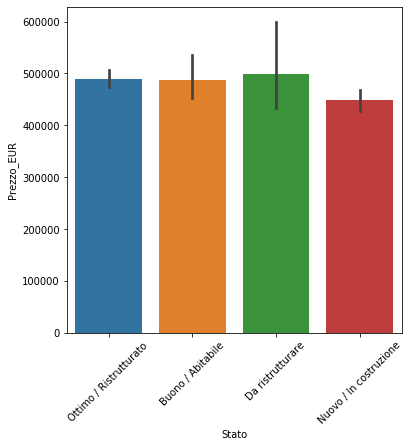

In [24]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Stato'], y=df['Prezzo_EUR'])
plt.xticks(rotation=45)

In [25]:
df['Stato'].value_counts()

Ottimo / Ristrutturato    4529
Buono / Abitabile         2404
Nuovo / In costruzione     897
Da ristrutturare           678
Name: Stato, dtype: int64

In [26]:
# Imputing "Stato" by most frequent as it does not seem to influence price much
df['Stato'] = df['Stato'].fillna(df['Stato'].value_counts().index[0])

#### Contract

In [27]:
# Looking into "Contratto": does it affect price?
gb = df['Prezzo_EUR'].groupby(df['Contratto']).agg('mean')
gb

Contratto
Vendita                         489644.840990
Vendita | Immobile a reddito    466355.491329
Name: Prezzo_EUR, dtype: float64

#### Dropping useless columns

In [28]:
# Drop columns that have almost no entries
# Dropping because of lack of entries
# Dropping "Disponibilità" and "Contratto" because it is not relevant information
df = df.drop(columns=['Immobile garantito', 'Indice prest. energetica rinnovabile',
                      'Prestazione energetica del fabbricato', 'Certificazione energetica',
                      'Disponibilità', 'Contratto'])

### Feature engineering

#### Heating

In [29]:
df['Riscaldamento'].isna().sum()

398

In [30]:
# Create type of heating feature
df['Tipologia di riscaldamento'] = df['Riscaldamento'].str.split(',').str[0]

(array([0, 1]), <a list of 2 Text xticklabel objects>)

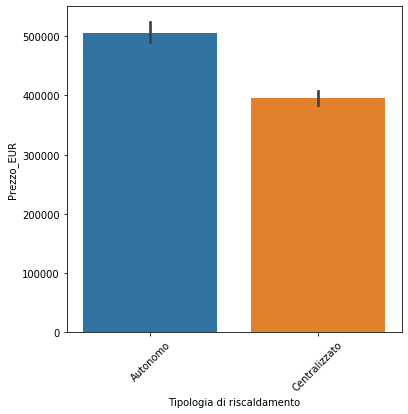

In [31]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Tipologia di riscaldamento'], y=df['Prezzo_EUR'])
plt.xticks(rotation=45)

In [32]:
df['Tipologia di riscaldamento'].value_counts()

Autonomo         6516
Centralizzato    1834
Name: Tipologia di riscaldamento, dtype: int64

In [33]:
# Filling heating NaNs with centralized as if not specified it is probably centralized
df['Tipologia di riscaldamento'] = df['Tipologia di riscaldamento'].fillna('Centralizzato')

#### Listing date

In [34]:
df['Riferimento e data annuncio'].head()

0       A0049 - 05/10/2020
1      alv275 - 05/10/2020
2    Novoli B - 05/10/2020
3    Novoli A - 05/10/2020
4     MAZZ328 - 05/10/2020
Name: Riferimento e data annuncio, dtype: object

In [35]:
df['Data annuncio'] = (df['Riferimento e data annuncio']
                       .str.split('-')
                       .str[-1]
                       .str.strip()
                       .astype('datetime64[D]'))

#### Floor

In [36]:
df['Piano'].unique()

array(['1° piano', '3° piano, con ascensore', '5° piano, con ascensore',
       'da seminterrato a 1°, con ascensore',
       'da seminterrato a piano terra, con ascensore, con accesso disabili',
       '3° piano', '2° piano', 'Piano terra', '1° piano, con ascensore',
       'Piano terra, con ascensore', 'Piano rialzato',
       'da 4° a 5°, con ascensore', '4° piano, con ascensore',
       'Piano rialzato, con ascensore', '6° piano, con ascensore',
       '2° piano, con ascensore, con accesso disabili', 'Seminterrato',
       'da piano terra a piano rialzato', '2° piano, con ascensore',
       'Piano rialzato, con ascensore, con accesso disabili',
       '1° piano, con ascensore, con accesso disabili',
       'Piano terra, con accesso disabili', '4° piano',
       '3° piano, con ascensore, con accesso disabili', nan,
       'da 5° a 6°, con ascensore',
       '5° piano, con ascensore, con accesso disabili',
       '7° piano, con ascensore',
       '4°, con ascensore, con accesso disab

In [37]:
mask = df['Piano'].str.match(r'(.*ascensore.*)')

df['Ascensore'] = mask.astype('float')

In [38]:
df['Totale piani edificio'] = (df['Totale piani edificio']
                               .str.split(' ')
                               .str[0]
                               .astype('float'))

In [39]:
df['Totale piani edificio'].isna().sum()

649

In [40]:
df['Altre caratteristiche'].str.replace('\n', ';')
df['Altre caratteristiche'].unique()[10]

'Giardino privato\n                \n\n                    Esposizione doppia'

#### Number of rooms and toilets

In [41]:
# Create number of rooms feature
pat = r'\(.*\)'
repl = lambda m: m.group(0).replace(',', ';')

df['Locali'] = df['Locali'].str.replace(pat, repl)

In [42]:
# Toilets
df['Numero di bagni'] = (df['Locali']
                         .str.findall(r'(\d\+? bagn\w)')
                         .str[0]
                         .str.split(' ')
                         .str[0])

df.loc[df['Numero di bagni'].isna(), 'Numero di bagni'] = 0
df.loc[df['Numero di bagni'] == '3+', 'Numero di bagni'] = 4 # Set 3+ toilets to 4
df['Numero di bagni'] = df['Numero di bagni'].astype('float')

df['Numero di bagni'].value_counts()

1.0    4428
2.0    2992
3.0     780
4.0     442
0.0     106
Name: Numero di bagni, dtype: int64

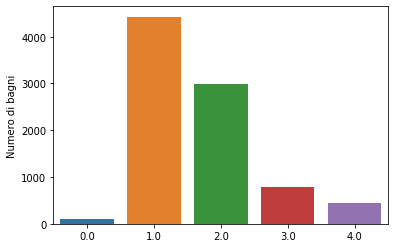

In [43]:
sns.barplot(x=df['Numero di bagni'].value_counts().index, y=df['Numero di bagni'].value_counts())

In [44]:
df.loc[df['Numero di bagni'] == 0, 'Superficie_m2']

99      120.0
119     500.0
329     250.0
409      95.0
441     200.0
        ...  
8657    350.0
8755     58.0
8773     21.0
8960    172.0
9041    200.0
Name: Superficie_m2, Length: 106, dtype: float64

In [45]:
# Create area bins for imputing
df['Superficie_Bins'] = pd.cut(df['Superficie_m2'].dropna(), bins=[0, 60, 80, 100, 120, 160, 200, 20000])

In [46]:
df['Superficie_Bins'].unique()

[(0.0, 60.0], (60.0, 80.0], (80.0, 100.0], (100.0, 120.0], (120.0, 160.0], (200.0, 20000.0], (160.0, 200.0], NaN]
Categories (7, interval[int64]): [(0, 60] < (60, 80] < (80, 100] < (100, 120] < (120, 160] < (160, 200] < (200, 20000]]

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

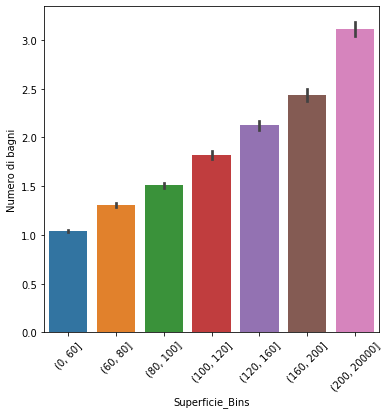

In [47]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_Bins'], y=df['Numero di bagni'])
plt.xticks(rotation=45)

In [48]:
df.groupby(['Superficie_Bins'])['Numero di bagni'].agg(lambda x:x.value_counts().index[0])

Superficie_Bins
(0, 60]         1.0
(60, 80]        1.0
(80, 100]       1.0
(100, 120]      2.0
(120, 160]      2.0
(160, 200]      2.0
(200, 20000]    4.0
Name: Numero di bagni, dtype: float64

In [49]:
# Imputing number of toilets based on area bins
for area in df['Superficie_Bins'].unique():
    mask = df['Superficie_Bins'] == area
    df.loc[mask & (df['Numero di bagni'] == 0), 'Numero di bagni'] = df.loc[mask, 'Numero di bagni'].mode().values

In [50]:
df['Numero di altri'] = (df['Locali']
                         .str.findall(r'(\d?\d\+? altr\w)')
                         .str[0]
                         .str.split(' ')
                         .str[0]
                         .astype('float'))
df.loc[df['Numero di altri'].isna(), 'Numero di altri'] = 0

In [51]:
df['Numero di camere da letto'] = (df['Locali']
                                   .str.findall(r'(\d?\d\+? camer\w da letto)')
                                   .str[0]
                                   .str.split(' ')
                                   .str[0]
                                   .astype('float'))
df.loc[df['Numero di camere da letto'].isna(), 'Numero di camere da letto'] = 0

In [52]:
df['Numero di locali'] = (df['Locali']
                          .str.findall(r'(\d?\d\+? local\w)')
                          .str[0]
                          .str.split(' ')
                          .str[0]
                          .astype('float'))
df.loc[df['Numero di locali'].isna(), 'Numero di locali'] = 0

In [53]:
df['Numero totale di locali'] = df['Numero di locali'] + df['Numero di camere da letto'] + df['Numero di altri']

In [54]:
df['Numero totale di locali'].isna().sum()

0

In [55]:
df.loc[df['Locali'].isna(), :].shape

(13, 30)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

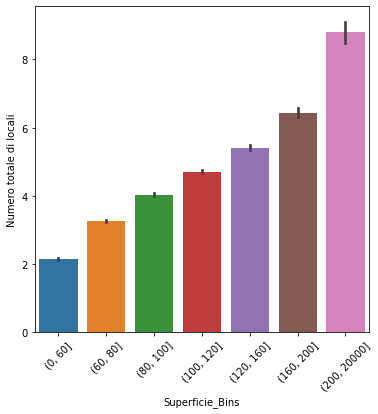

In [56]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_Bins'], y=df['Numero totale di locali'])
plt.xticks(rotation=45)

In [57]:
# Imputing number of rooms based on area bins
for area in df['Superficie_Bins'].unique():
    mask = df['Superficie_Bins'] == area
    df.loc[mask & (df['Numero totale di locali'] == 0),
           'Numero totale di locali'] = df.loc[mask, 'Numero totale di locali'].mode().values

In [58]:
df.loc[mask & (df['Numero totale di locali'] == 0), 'Numero totale di locali']

Series([], Name: Numero totale di locali, dtype: float64)

In [59]:
df.loc[df['Numero totale di locali'].isna(), :].shape

(0, 30)

#### Imputing area

In [60]:
df.loc[df['Superficie_m2'].isna(), :]

,Riferimento e data annuncio,Tipologia,Superficie,Locali,Piano,Totale piani edificio,Tipo proprietà,Altre caratteristiche,Posti auto,Indirizzo,Zona,Prezzo,Informazioni catastali,Spese condominio,Anno di costruzione,Stato,Riscaldamento,Climatizzazione,Efficienza energetica,Prezzo_EUR,Superficie_m2,Tipologia di riscaldamento,Data annuncio,Ascensore,Numero di bagni,Superficie_Bins,Numero di altri,Numero di camere da letto,Numero di locali,Numero totale di locali
5541,VE345CATFA/12 - 28/09/2020,Appartamento,NaN,"5+ (3 camere da letto; 3 altri), 3 bagni, cuci...",Su più livelli,2.0,NaN,Terrazza\n \n\n ...,1 all'esterno,"Firenze, Campo di Marte, VIA CARNESECCHI",Campo Di Marte Liberta,€ 495.000,NaN,NaN,1600.0,Nuovo / In costruzione,"Autonomo, a radiatori",NaN,"G 175,00 kWh/m² anno",495000.0,NaN,Autonomo,2020-09-28,0.0,3.0,NaN,3.0,3.0,0.0,6.0
5543,VE345CATFA/7 - 28/09/2020,Appartamento,NaN,"5+ (2 camere da letto; 4 altri), 2 bagni, cuci...",Su più livelli,2.0,NaN,Terrazza\n \n\n ...,1 all'esterno,"Firenze, Campo di Marte, VIA CARNESECCHI",Campo Di Marte Liberta,€ 695.000,NaN,NaN,1600.0,Nuovo / In costruzione,"Autonomo, a radiatori",NaN,"G 175,00 kWh/m² anno",695000.0,NaN,Autonomo,2020-09-28,0.0,2.0,NaN,4.0,2.0,0.0,6.0
5544,VE345CATFA/9 - 28/09/2020,Appartamento,NaN,"4 (2 camere da letto; 2 altri), 3 bagni, cucin...",1° piano,2.0,NaN,Balcone,NaN,"Firenze, Campo di Marte, VIA CARNESECCHI",Campo Di Marte Liberta,€ 565.000,NaN,NaN,1600.0,Nuovo / In costruzione,NaN,NaN,"G 175,00 kWh/m² anno",565000.0,NaN,Centralizzato,2020-09-28,0.0,3.0,NaN,2.0,2.0,0.0,4.0
5850,RIF.4062 - 21/04/2020,Appartamento,NaN,"5 locali, 2 bagni, cucina abitabile",NaN,NaN,"Intera proprietà, immobile di lusso",Idromassaggio\n \n\n ...,NaN,"Firenze, Salviatino - San Domenico",Zona Bolognese Le Cure,€ 1.560.000,NaN,€ 1/mese,1500.0,Ottimo / Ristrutturato,"Autonomo, a radiatori, alimentato a gas","Autonomo, freddo","G 176,00 kWh/m² anno",1560000.0,NaN,Autonomo,2020-04-21,NaN,2.0,NaN,0.0,0.0,5.0,5.0
5879,RIF.1542 - 29/07/2020,Villa unifamiliare,NaN,"5+ (3 camere da letto; 5 altri), 3+ bagni, cuc...","Piano terra, con ascensore",1.0,"Intera proprietà, immobile di lusso",Idromassaggio\n \n\n ...,NaN,"Firenze, Bolognese",Zona Bolognese Le Cure,€ 1.700.000,"Classe A/7, rendita € 1",€ 1/mese,1960.0,Ottimo / Ristrutturato,"Autonomo, a radiatori, alimentato a gas","Autonomo, freddo/caldo","G 176,00 kWh/m² anno",1700000.0,NaN,Autonomo,2020-07-29,1.0,4.0,NaN,5.0,3.0,0.0,8.0
5897,RIF.1547 - 21/04/2020,Villa unifamiliare,NaN,"5 locali, 3+ bagni, cucina abitabile",NaN,NaN,"Intera proprietà, immobile di lusso",Idromassaggio\n \n\n ...,NaN,"Firenze, Galluzzo",Bellosguardo Galluzzo,€ 3.300.000,NaN,€ 1/mese,1472.0,Ottimo / Ristrutturato,"Autonomo, a radiatori, alimentato a gas","Autonomo, freddo","G 176,00 kWh/m² anno",3300000.0,NaN,Autonomo,2020-04-21,NaN,4.0,NaN,0.0,0.0,5.0,5.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

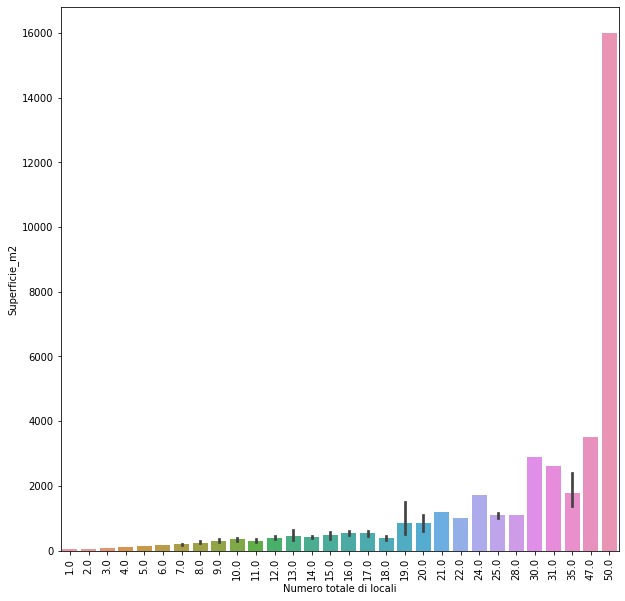

In [61]:
fig = plt.figure(figsize=(10, 10))
sns.barplot(x=df['Numero totale di locali'], y=df['Superficie_m2'])
plt.xticks(rotation=90)

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <a list of 11 Text xticklabel objects>)

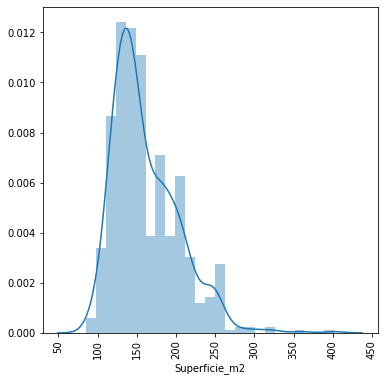

In [62]:
fig = plt.figure(figsize=(6, 6))
sns.distplot(df.loc[df['Numero totale di locali'] == 6, 'Superficie_m2'])
plt.xticks(rotation=90)

In [63]:
# Imputing area based on total number of rooms
for n_rooms in df['Numero totale di locali'].unique():
    mask = df['Numero totale di locali'] == n_rooms
    df.loc[mask & (df['Superficie_m2'].isna()), 'Superficie_m2'] = df.loc[mask, 'Superficie_m2'].mean()

In [64]:
# Recreate area bins for imputing
df['Superficie_Bins'] = pd.cut(df['Superficie_m2'], bins=[0, 60, 80, 100, 120, 160, 200, 20000])

#### Price per m2

In [65]:
# Create a price/m2 feature
df['Prezzo_per_m2'] = df['Prezzo_EUR'] / df['Superficie_m2']

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8748 entries, 0 to 9062
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Riferimento e data annuncio  8748 non-null   object        
 1   Tipologia                    8748 non-null   object        
 2   Superficie                   8742 non-null   object        
 3   Locali                       8735 non-null   object        
 4   Piano                        8583 non-null   object        
 5   Totale piani edificio        8099 non-null   float64       
 6   Tipo proprietà               8292 non-null   object        
 7   Altre caratteristiche        8190 non-null   object        
 8   Posti auto                   2150 non-null   object        
 9   Indirizzo                    8748 non-null   object        
 10  Zona                         8748 non-null   object        
 11  Prezzo                       8748 non-null 

### Selecting final features

In [67]:
features = ['Data annuncio', 'Zona', 'Prezzo_EUR', 'Tipologia', 'Superficie_m2', 'Superficie_Bins',
            'Prezzo_per_m2', 'Numero totale di locali', 'Numero di bagni', 'Stato', 'Tipologia di riscaldamento']

df_final = df[features].copy()

In [68]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8748 entries, 0 to 9062
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Data annuncio               8748 non-null   datetime64[ns]
 1   Zona                        8748 non-null   object        
 2   Prezzo_EUR                  8748 non-null   float64       
 3   Tipologia                   8748 non-null   object        
 4   Superficie_m2               8748 non-null   float64       
 5   Superficie_Bins             8748 non-null   category      
 6   Prezzo_per_m2               8748 non-null   float64       
 7   Numero totale di locali     8748 non-null   float64       
 8   Numero di bagni             8748 non-null   float64       
 9   Stato                       8748 non-null   object        
 10  Tipologia di riscaldamento  8748 non-null   object        
dtypes: category(1), datetime64[ns](1), float64(5), object(4)

## 2. Exploratory Data Analysis

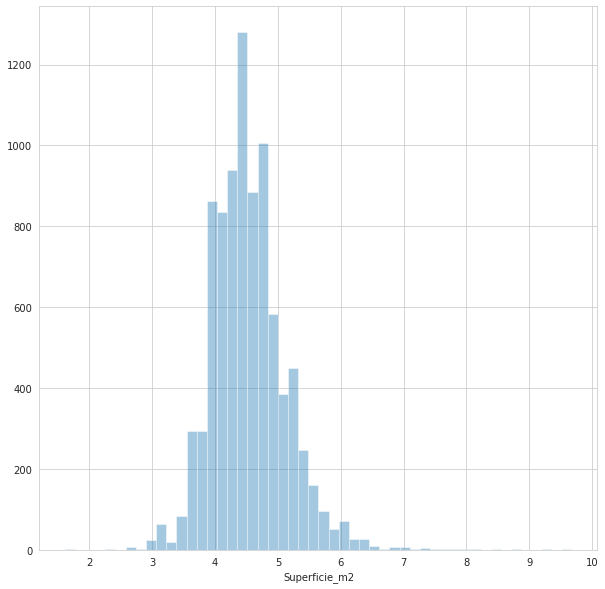

In [69]:
# Area [m2] distribution - take log to normalize
fig = plt.figure(figsize=(10, 10))
sns.set_style('whitegrid')
sns.distplot(np.log(df_final['Superficie_m2']), kde=False)

In [70]:
df_final['Superficie_m2'].describe()

count     8748.000000
mean       118.471275
std        263.113562
min          5.000000
25%         64.000000
50%         90.000000
75%        125.000000
max      16000.000000
Name: Superficie_m2, dtype: float64

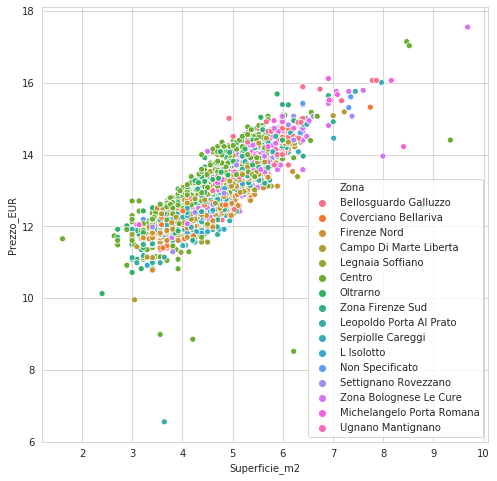

In [71]:
# Relationship between price and area - take log to normalize
fig = plt.figure(figsize=(8, 8))
sns.set_style('whitegrid')
sns.scatterplot(x=np.log(df['Superficie_m2']), y=np.log(df['Prezzo_EUR']), hue=df['Zona'])

There is a clear linear relationship between the price and the area where greater area means higher price. It is however difficult to distinguish the various areas in Florence.

In [72]:
df_final['Prezzo_EUR'].describe()

count    8.748000e+03
mean     4.887237e+05
std      7.997157e+05
min      7.000000e+02
25%      2.480000e+05
50%      3.400000e+05
75%      5.091000e+05
max      4.200000e+07
Name: Prezzo_EUR, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

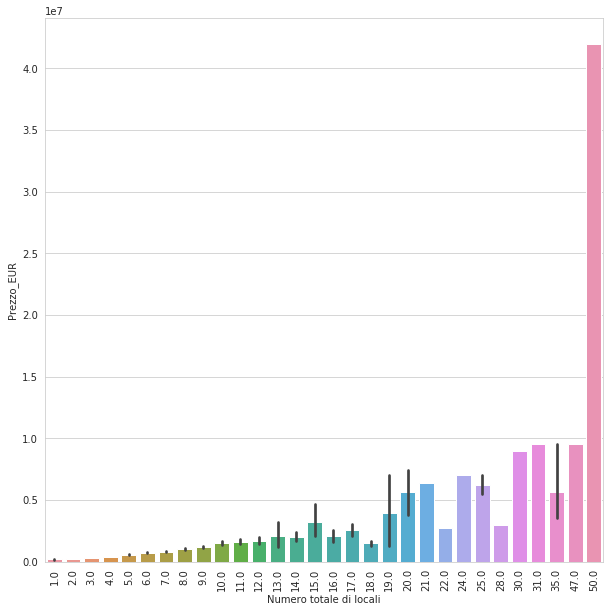

In [73]:
fig = plt.figure(figsize=(10, 10))
sns.set_style('whitegrid')
sns.barplot(y=df_final['Prezzo_EUR'], x=df_final['Numero totale di locali'])
plt.xticks(rotation=90)

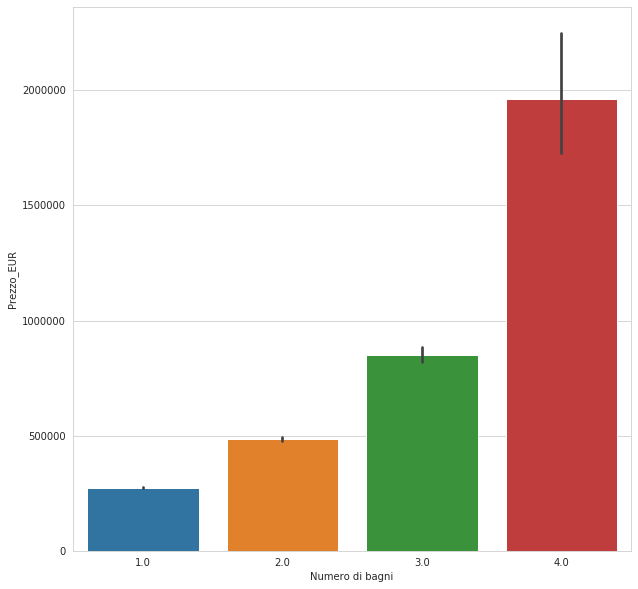

In [74]:
fig = plt.figure(figsize=(10, 10))
sns.set_style('whitegrid')
sns.barplot(y=df_final['Prezzo_EUR'], x=df_final['Numero di bagni'])

Text(0.5, 1.0, 'Average price per area')

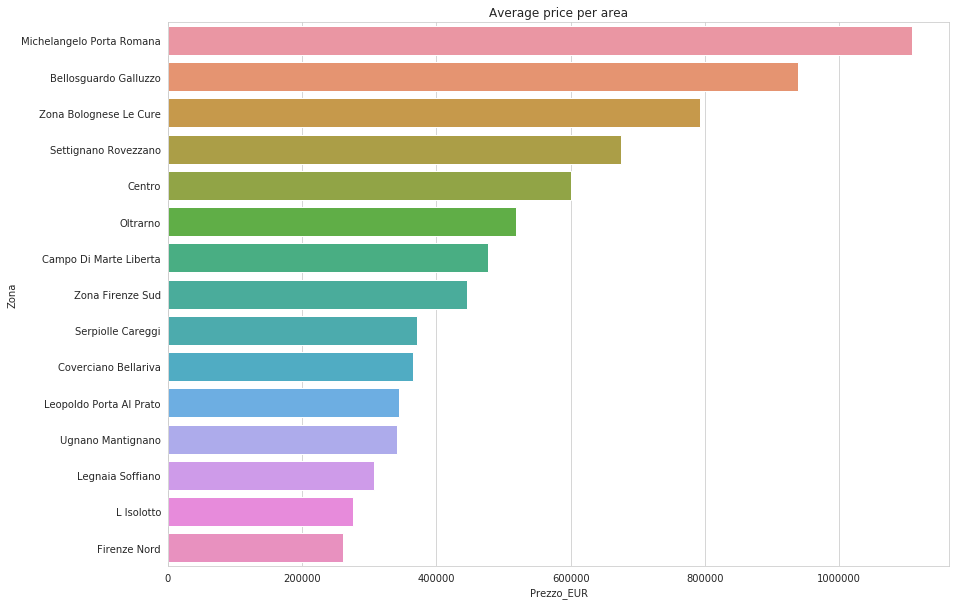

In [75]:
gb_ordered = (df_final.loc[df_final['Zona']!='Non Specificato', :]
              .groupby(['Zona'])
              .agg({'Prezzo_EUR': 'mean'})
              .sort_values('Prezzo_EUR', ascending=False))

fig = plt.figure(figsize=(14, 10))
sns.barplot(gb_ordered['Prezzo_EUR'], y=gb_ordered.index, ci=None)
plt.title('Average price per area')

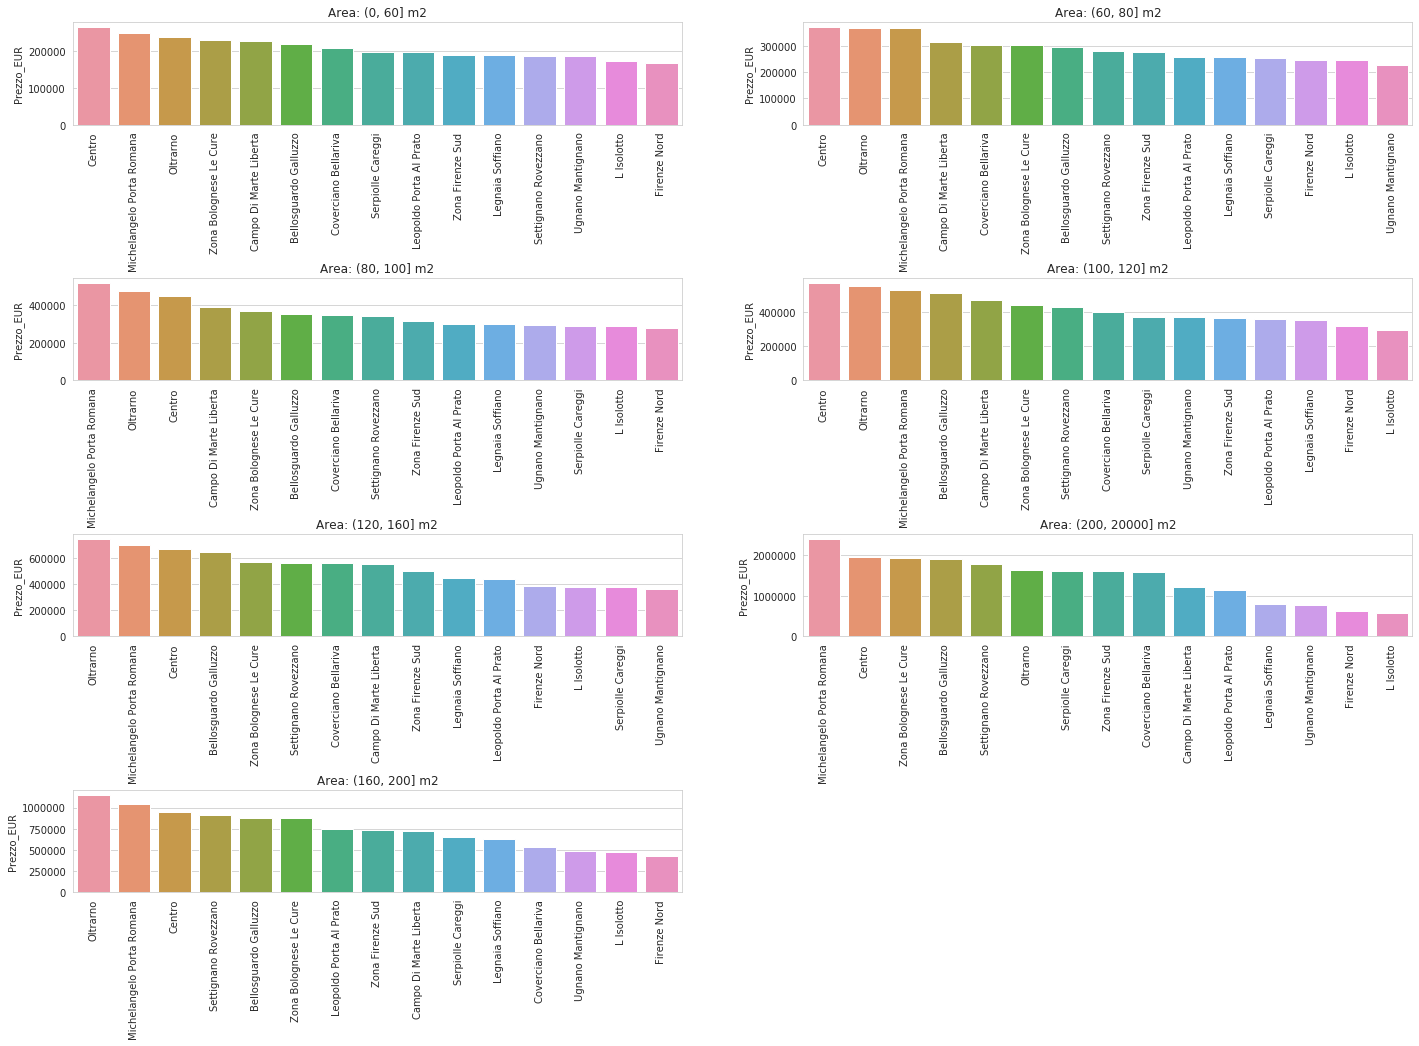

In [76]:
gb_ordered = (df_final.loc[df_final['Zona']!='Non Specificato', :]
              .groupby(['Superficie_Bins', 'Zona'])
              .agg({'Prezzo_EUR': 'mean'})
              .sort_values('Prezzo_EUR', ascending=False))

fig = plt.figure(figsize=(24, 16))
sns.set_style('whitegrid')
for i, area in enumerate(df_final['Superficie_Bins'].unique(), 1):
    y_values = gb_ordered.loc[gb_ordered.index.get_level_values('Superficie_Bins').values==area, 'Prezzo_EUR'].reset_index(level=0, drop=True)
    x_values = y_values.index

    plt.subplot(4, 2, i,)
    sns.barplot(y=y_values, x=x_values, ci=None)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5)
    plt.xlabel(xlabel=None)
    plt.title('Area: ' + str(area) + ' m2')
    plt.xticks(rotation=90)

Text(0.5, 1.0, 'Average price per m2 per area')

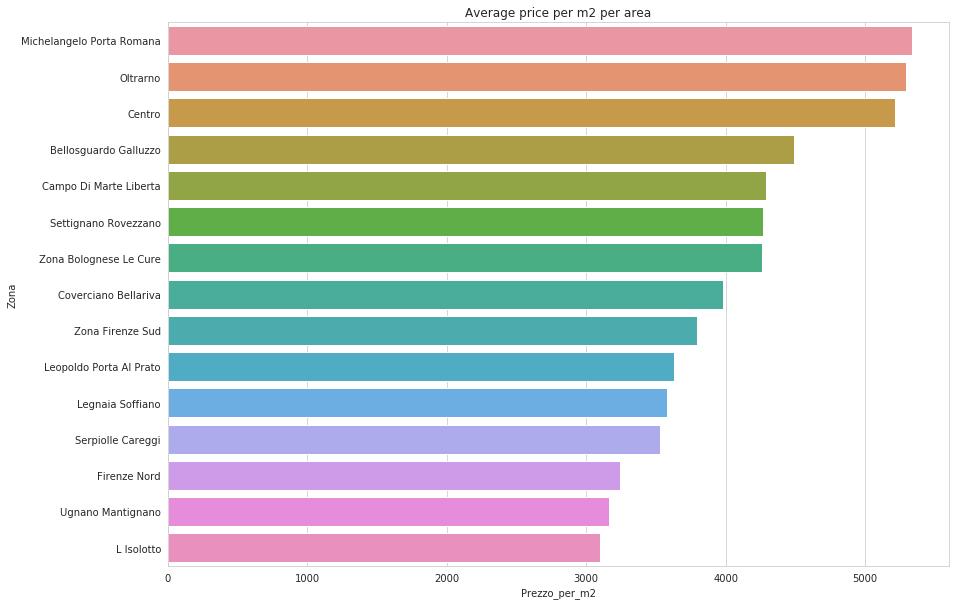

In [77]:
gb_ordered = (df_final.loc[df_final['Zona']!='Non Specificato', :]
              .groupby(['Zona'])
              .agg({'Prezzo_per_m2': 'mean'})
              .sort_values('Prezzo_per_m2', ascending=False))

fig = plt.figure(figsize=(14, 10))
sns.barplot(gb_ordered['Prezzo_per_m2'], y=gb_ordered.index, ci=None)
plt.title('Average price per m2 per area')

In [78]:
df['Zona'].value_counts()

Centro                       1666
Campo Di Marte Liberta       1342
Leopoldo Porta Al Prato       896
Firenze Nord                  876
Serpiolle Careggi             615
Coverciano Bellariva          558
Oltrarno                      558
Zona Bolognese Le Cure        452
Zona Firenze Sud              424
Legnaia Soffiano              376
Bellosguardo Galluzzo         276
Settignano Rovezzano          241
L Isolotto                    238
Michelangelo Porta Romana     170
Ugnano Mantignano              33
Non Specificato                27
Name: Zona, dtype: int64

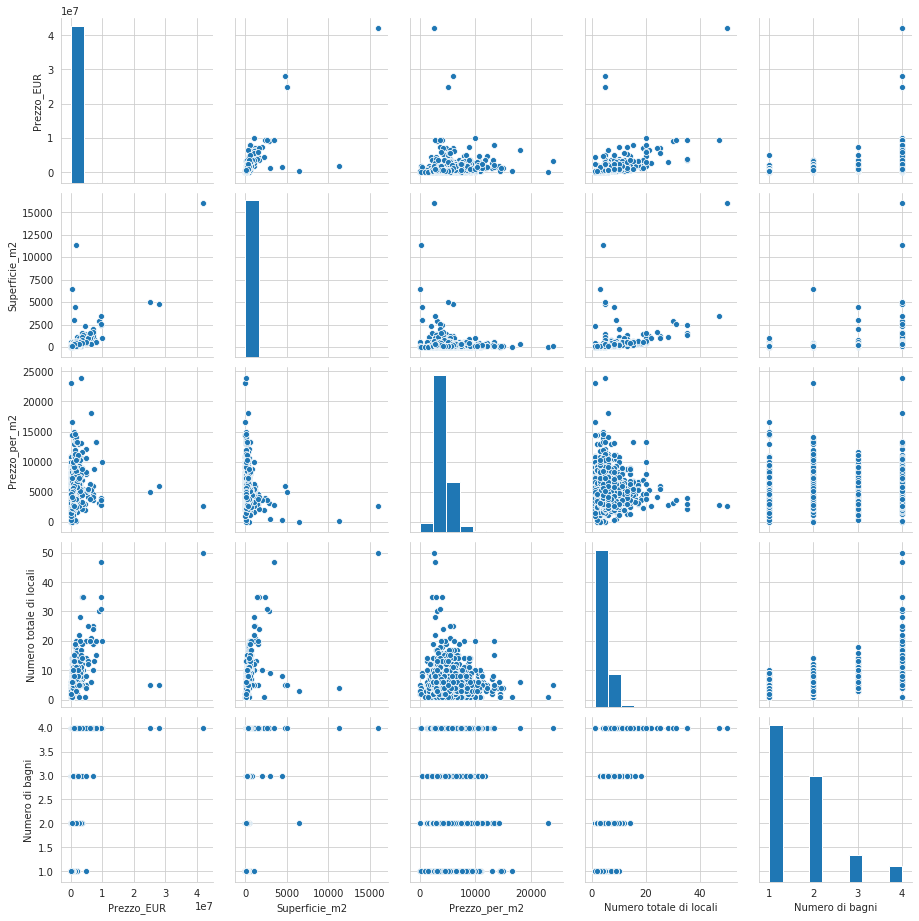

In [79]:
sns.pairplot(df_final)

## 3. Modeling

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [81]:
features = ['Zona', 'Tipologia', 'Superficie_m2', 'Numero totale di locali',
            'Numero di bagni', 'Stato', 'Tipologia di riscaldamento']
target = 'Prezzo_EUR'
X = df_final[features]
y = df_final[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### One-hot encoding

In [82]:
cat_cols = ['Zona', 'Tipologia', 'Stato', 'Tipologia di riscaldamento']

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore')
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[cat_cols]).toarray(),
                             columns=OH_encoder.get_feature_names())
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[cat_cols]).toarray(),
                            columns=OH_encoder.get_feature_names())

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(cat_cols, axis=1)
num_X_test = X_test.drop(cat_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

### Scaling

In [83]:
scaler = StandardScaler()

X_train['Superficie_m2'] = scaler.fit_transform(X_train[['Superficie_m2']])
X_test['Superficie_m2'] = scaler.transform(X_test[['Superficie_m2']])

### First model

In [84]:
# Import metrics
from sklearn.metrics import mean_absolute_error

In [85]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# Train set score
#print('Training set score: {}'.format(reg.score(X_train, y_train)))
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Test set score: {}'.format(mean_absolute_error(y_test, y_test_pred)))

Training set score: 149548.55356190543
Test set score: 142669.05359819997


### Other models

In [86]:
from sklearn.ensemble import RandomForestRegressor

rdmf = RandomForestRegressor(random_state=0)
rdmf.fit(X_train, y_train)

y_train_pred = rdmf.predict(X_train)
y_test_pred = rdmf.predict(X_test)

print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Test set score: {}'.format(mean_absolute_error(y_test, y_test_pred)))

Training set score: 45952.00349853058
Test set score: 98000.99595632931


In [87]:
from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor()
KNN.fit(X_train, y_train)

y_train_pred = KNN.predict(X_train)
y_test_pred = KNN.predict(X_test)

print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Test set score: {}'.format(mean_absolute_error(y_test, y_test_pred)))

Training set score: 101105.79897113462
Test set score: 106317.64868571427


In [88]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Test set score: {}'.format(mean_absolute_error(y_test, y_test_pred)))

[15:17:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training set score: 91639.12268795549
Test set score: 105199.22660714286


### Hyperparameter tuning

In [89]:
from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


grid_search = GridSearchCV(rdmf, param_grid, cv=5, verbose=1, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 